In [1]:
import os
import itertools
import time
import json
import tqdm

import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.model_selection import KFold, train_test_split

# Feature scaling, required for non-tree-based models
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats.mstats import winsorize

# Encoding categorical data for non-tree-based models
from sklearn.preprocessing import OneHotEncoder

#from fbprophet import Prophet

In [2]:
# goods_promote_price = pd.read_csv('../datasets/goods_promote_price.csv', low_memory=True, thousands=',')
# goods_sku_relation = pd.read_csv('../datasets/goods_sku_relation.csv', low_memory=True, thousands=',')
goodsale = pd.read_csv('../datasets/goodsale.csv', low_memory=True, thousands=',')
# goodsdaily = pd.read_csv('../datasets/goodsdaily.csv', low_memory=True, thousands=',')
# marketing = pd.read_csv('../datasets/marketing.csv', low_memory=True, thousands=',')
# goodsinfo = pd.read_csv('../datasets/goodsinfo.csv', low_memory=True, thousands=',')

submit_example = pd.read_csv('../datasets/submit_example.csv', low_memory = True, thousands = ',')

In [3]:
#2018.10.17 For Test 2
grouped_goodsale = goodsale.groupby(goodsale['sku_id'])
grouped_goodsale.get_group('SKCRtFMV')

,data_date,goods_id,sku_id,goods_num,goods_price,orginal_shop_price
92846,20170316,GJhlni,SKCRtFMV,6,36.99,40.99
135114,20170929,GJhlni,SKCRtFMV,2,30.99,40.99
204778,20170814,GJhlni,SKCRtFMV,4,29.99,40.99
229538,20170916,GJhlni,SKCRtFMV,3,31.99,40.99
248992,20170620,GJhlni,SKCRtFMV,2,29.99,40.99
265558,20171027,GJhlni,SKCRtFMV,3,29.99,40.99
285303,20170809,GJhlni,SKCRtFMV,2,29.99,40.99
453094,20170805,GJhlni,SKCRtFMV,1,29.99,40.99
514475,20170422,GJhlni,SKCRtFMV,7,30.99,40.99
533734,20170521,GJhlni,SKCRtFMV,3,30.99,40.99


In [4]:
#2018.10.17 For Test
mean_temp = goodsale.merge(submit_example, on = 'sku_id')
sum_temp = mean_temp[(mean_temp['data_date'] >= 20180124) & (mean_temp['data_date'] < 20180400)]
sum_temp = sum_temp.groupby(by = 'data_date', as_index = False).sum()


In [5]:
total_sell = sum_temp.apply(sum, axis = 0)
total_sell = total_sell[1]
total_sell

1602038.0

In [6]:
total_sell / 52 * 7

215658.96153846156

In [7]:
sim_goodsale = goodsale.drop(['goods_id', 'goods_price', 'orginal_shop_price'], axis = 1)
sim_goodsale.head()

,data_date,sku_id,goods_num
0,20170518,SKg8D0d7,1
1,20171219,SKzkS30M,1
2,20170427,SKDZNsaw,3
3,20170720,SKZAlwv2,2
4,20170906,SKlIemMi,1


In [ ]:
#太慢了 爆内存
list_goodsale = list(goodsale['sku_id'])

for item in list_goodsale:
    temp_goodsale = sim_goodsale[sim_goodsale['sku_id'] == item]
    temp_goodsale.head()

In [ ]:
temp = sim_goodsale.groupby(goodsale['sku_id'])


In [ ]:
temp.get_group('SKg8D0d7')

In [ ]:
temp.get_group('SKg8D0d7')

In [ ]:
####Back UP From Kargle
import os
import itertools
import time
import json
import tqdm

import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
%matplotlib inline

from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.model_selection import KFold, train_test_split

# Feature scaling, required for non-tree-based models
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats.mstats import winsorize

# Encoding categorical data for non-tree-based models
from sklearn.preprocessing import OneHotEncoder

from fbprophet import Prophet

from tqdm import tqdm as tqdm


In [8]:
goodsale = pd.read_csv('../datasets/goodsale.csv', low_memory=True, thousands=',')


In [9]:
goodsale["data_date"] = goodsale.data_date.map(lambda data:str(data))
goodsale["data_date"] = pd.to_datetime(goodsale.data_date)

In [10]:
goodsale.head()

,data_date,goods_id,sku_id,goods_num,goods_price,orginal_shop_price
0,2017-05-18,GIxOHa,SKg8D0d7,1,1.99,1.99
1,2017-12-19,GfvDCS,SKzkS30M,1,10.99,15.99
2,2017-04-27,GrwmCH,SKDZNsaw,3,30.99,44.99
3,2017-07-20,GIbEyJ,SKZAlwv2,2,6.99,14.99
4,2017-09-06,G3B1xG,SKlIemMi,1,9.99,12.99


In [ ]:
goodsale.groupby('data_date', as_index = False).sum()

In [11]:
full_date = goodsale[['data_date']] #筛选date
full_date = full_date.drop_duplicates() #去重
full_date = full_date.sort_values(by = 'data_date') #排序
full_date

# full_date.to_csv('../submissions/full_date.csv')

,data_date
190,2017-03-01
330,2017-03-02
1197,2017-03-03
726,2017-03-04
2161,2017-03-05
600,2017-03-06
1116,2017-03-07
5,2017-03-08
740,2017-03-09
356,2017-03-10


In [26]:
goodsale["data_date"] = goodsale.data_date.map(lambda data:str(data))
goodsale["data_date"] = pd.to_datetime(goodsale.data_date)

KeyboardInterrupt: 

In [27]:
%%time
sim_goodsale = goodsale[['sku_id', 'data_date', 'goods_num']]

Wall time: 373 ms


In [28]:
sim_goodsale.sort_values(by = ['data_date'])
sim_goodsale.head()

,sku_id,data_date,goods_num
0,SKg8D0d7,2017-05-18,1
1,SKzkS30M,2017-12-19,1
2,SKDZNsaw,2017-04-27,3
3,SKZAlwv2,2017-07-20,2
4,SKlIemMi,2017-09-06,1


In [ ]:
grouped_goodsale = sim_goodsale.groupby(goodsale['sku_id'])
ttt = grouped_goodsale.get_group('SKg8D0d7').sort_values(by = ['data_date'])

train = ttt[["date", "goods_num"]]
train = ttt.rename(columns = {'date': 'ds',
                                'goods_num': 'y'})

In [ ]:
%%time
#正文
#full_data_date = 

list_goodsale = list(goodsale['sku_id'])
for item in tqdm(list_goodsale):
    None
#     item_df = grouped_goodsale.get_group(item).sort_values(by = ['data_date'])
    
#     train = item_df[["date", "goods_num"]]
#     train = train.rename(columns = {'date': 'ds','goods_num': 'y'})
    #item_df

In [12]:
##############################################################################     2018.10.18      #############################
somesale = goodsale.merge(submit_example)
sim_goodsale = somesale[['sku_id', 'goods_num', 'data_date']]
sim_goodsale

,sku_id,goods_num,data_date
0,SKDZNsaw,3,2017-04-27
1,SKDZNsaw,10,2017-06-05
2,SKDZNsaw,3,2017-07-24
3,SKDZNsaw,1,2017-12-22
4,SKDZNsaw,1,2017-07-06
5,SKDZNsaw,4,2017-04-18
6,SKDZNsaw,1,2017-05-14
7,SKDZNsaw,2,2017-09-21
8,SKDZNsaw,1,2018-01-15
9,SKDZNsaw,1,2017-12-08


In [29]:
# sim_goodsale['data_date'] = sim_goodsale.data_date.map(lambda data:str(data))
# sim_goodsale['data_date'] = pd.to_datetime(sim_goodsale.data_date)


In [30]:
sim_goodsale

,sku_id,data_date,goods_num
0,SKg8D0d7,2017-05-18,1
1,SKzkS30M,2017-12-19,1
2,SKDZNsaw,2017-04-27,3
3,SKZAlwv2,2017-07-20,2
4,SKlIemMi,2017-09-06,1
5,SKCDfdcA,2017-03-08,1
6,SKzsyOI2,2017-10-30,1
7,SKE3Rm8a,2017-08-30,2
8,SKhseGSf,2018-03-08,1
9,SKwyIpX5,2017-06-26,1


In [31]:
all_sim_goodsale = sim_goodsale.groupby('data_date', as_index = False).sum()

In [32]:
all_sim_goodsale

,data_date,goods_num
0,2017-03-01,25795
1,2017-03-02,24455
2,2017-03-03,24489
3,2017-03-04,26601
4,2017-03-05,26111
5,2017-03-06,24595
6,2017-03-07,24081
7,2017-03-08,23222
8,2017-03-09,23222
9,2017-03-10,23713


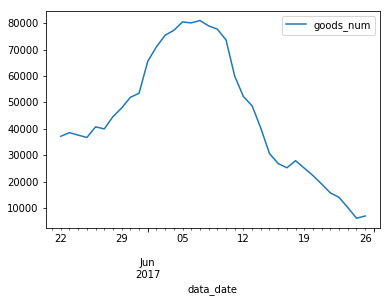

In [41]:
# plt.plot(all_sim_goodsale)
# all_sim_goodsale[(all_sim_goodsale['data_date'] >= '2017-11-01') & (all_sim_goodsale['data_date'] <= '2017-11-30')]


all_sim_goodsale[(all_sim_goodsale['data_date'] >= '2017-05-22') & 
                 (all_sim_goodsale['data_date'] <= '2017-06-26')].plot(x = 'data_date', y = 'goods_num')
#21-01 == 1
#01-03 == 2
#04-26 == 3

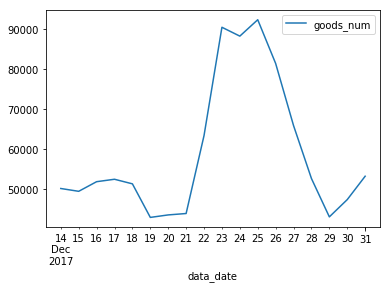

In [45]:
all_sim_goodsale[(all_sim_goodsale['data_date'] >= '2017-12-14') & 
                 (all_sim_goodsale['data_date'] <= '2017-12-31')].plot(x = 'data_date', y = 'goods_num')
#14-22 ==1
#23-26 ==2
#27-31 ==3

#活动2的前后各一天效果都还可以

In [ ]:
#11月份销量放缩
# New 11月份销量 = Old 11月份销量 * 11月日均销量 / 全年日均销量
#11.10 - 11.27
#期间18天

In [34]:
all_sim_goodsale.sum() / 380

goods_num    30509.255263
dtype: float64

In [36]:
all_sim_goodsale[(all_sim_goodsale['data_date'] >= '2017-11-10') & 
                 (all_sim_goodsale['data_date'] <= '2017-11-27')].sum() / 18

goods_num    123479.722222
dtype: float64

In [49]:
all_sim_goodsale[(all_sim_goodsale['data_date'] >= '2017-11-10') & 
                 (all_sim_goodsale['data_date'] <= '2017-11-27')]

,data_date,goods_num
254,2017-11-10,51051
255,2017-11-11,65849
256,2017-11-12,79039
257,2017-11-13,85445
258,2017-11-14,84374
259,2017-11-15,89024
260,2017-11-16,101425
261,2017-11-17,138759
262,2017-11-18,140634
263,2017-11-19,88335


In [95]:
# all_sim_goodsale[(all_sim_goodsale['data_date'] >= '2017-11-10') & 
#                  (all_sim_goodsale['data_date'] <= '2017-11-27')][['goods_num']] = all_sim_goodsale[(all_sim_goodsale['data_date'] >= '2017-11-10') & 
#                  (all_sim_goodsale['data_date'] <= '2017-11-27')][['goods_num']] + 10000
# all_sim_goodsale[(all_sim_goodsale['data_date'] >= '2017-11-10') & 
#                  (all_sim_goodsale['data_date'] <= '2017-11-27')] *= 2
# num = all_sim_goodsale[(all_sim_goodsale['data_date'] >= '2017-11-10') & 
#                  (all_sim_goodsale['data_date'] <= '2017-11-27')]._get_numeric_data()
# num *= 2
all_sim_goodsale.loc[(all_sim_goodsale['data_date'] >= '2017-11-10') & 
                 (all_sim_goodsale['data_date'] <= '2017-11-27'),'goods_num'] *= 2
all_sim_goodsale[(all_sim_goodsale['data_date'] >= '2017-11-10') & 
                 (all_sim_goodsale['data_date'] <= '2017-11-27')]

,data_date,goods_num
254,2017-11-10,204204
255,2017-11-11,263396
256,2017-11-12,316156
257,2017-11-13,341780
258,2017-11-14,337496
259,2017-11-15,356096
260,2017-11-16,405700
261,2017-11-17,555036
262,2017-11-18,562536
263,2017-11-19,353340


In [84]:
test[['goods_num']] *= 2

e:\python3.6.1\lib\site-packages\pandas\core\frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [72]:
all_sim_goodsale[(all_sim_goodsale['data_date'] >= '2017-11-10') & 
                 (all_sim_goodsale['data_date'] <= '2017-11-27')]

,data_date,goods_num
254,2017-11-10,51051
255,2017-11-11,65849
256,2017-11-12,79039
257,2017-11-13,85445
258,2017-11-14,84374
259,2017-11-15,89024
260,2017-11-16,101425
261,2017-11-17,138759
262,2017-11-18,140634
263,2017-11-19,88335
